In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
!pip install mne

In [3]:
!pip install opencv-python

In [4]:
!pip install warmup-scheduler

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable

In [6]:
#from net import resnet18, resnet34, resnet50, resnet101, resnet152

import torch
import torch.nn as nn
import numpy as np
# import pandas as pd
import tqdm
import mit_utils as utils
# import analytics
import time
import os, shutil

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import random

from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

import argparse



from scipy import signal

import math
import cv2

import random

In [7]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        
        
def do_plot(train_loss, valid_loss):
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.title('loss {}'.format(iter))
    plt.legend()
    plt.show()

In [8]:
import torch.nn.functional as F

def save_ckpt(state, is_best, model_save_dir, message='best_w.pth'):
    current_w = os.path.join(model_save_dir, 'latest_w.pth')
    best_w = os.path.join(model_save_dir, message)
    torch.save(state, current_w)
    if is_best: shutil.copyfile(current_w, best_w)

def transform(x, mode):
    x_ = x.cpu().numpy()

    Trans = Transform()
    if mode == 'time_warp':
        pieces = random.randint(5,20)
        stretch = random.uniform(1.5,4)
        squeeze = random.uniform(0.25,0.67)
        x_ = Trans.time_warp(x_, 100, pieces, stretch, squeeze)
    elif mode == 'noise':
        factor = random.uniform(10,20)
        x_ = Trans.add_noise_with_SNR(x_,factor)
    elif mode == 'scale':
        x_ = Trans.scaled(x_,[0.3,3])
    elif mode == 'negate':
        x_ = Trans.negate(x_)
    elif mode == 'hor_flip':
        x_ = Trans.hor_filp(x_)
        
    elif mode == 'permute':
        pieces = random.randint(5,20)
        x_ = Trans.permute(x_,pieces)
        
    elif mode == 'cutout_resize':
        pieces = random.randint(5, 20)
        x_ = Trans.cutout_resize(x_, pieces)
    elif mode == 'cutout_zero':
        pieces = random.randint(5, 20)
        x_ = Trans.cutout_zero(x_, pieces)
    elif mode == 'crop_resize':
        size = random.uniform(0.25,0.75)
        x_ = Trans.crop_resize(x_, size)
    elif mode == 'move_avg':
        n = random.randint(3, 10)
        x_ = Trans.move_avg(x_,n, mode="same")
    #     to test
    elif mode == 'lowpass':
        order = random.randint(3, 10)
        cutoff = random.uniform(5,20)
        x_ = Trans.lowpass_filter(x_, order, [cutoff])
    elif mode == 'highpass':
        order = random.randint(3, 10)
        cutoff = random.uniform(5, 10)
        x_ = Trans.highpass_filter(x_, order, [cutoff])
    elif mode == 'bandpass':
        order = random.randint(3, 10)
        cutoff_l = random.uniform(1, 5)
        cutoff_h = random.uniform(20, 40)
        cutoff = [cutoff_l, cutoff_h]
        x_ = Trans.bandpass_filter(x_, order, cutoff)

    else:
        print("Error")

    x_ = x_.copy()
    x_ = x_[:,None,:]
    return x_

def comtrast_loss(x, criterion):
    LARGE_NUM = 1e9
    temperature = 0.1
    x = F.normalize(x, dim=-1)

    num = int(x.shape[0] / 2)
    hidden1, hidden2 = torch.split(x, num)


    hidden1_large = hidden1
    hidden2_large = hidden2
    labels = torch.arange(0,num).to(device)
    masks = F.one_hot(torch.arange(0,num), num).to(device)


    logits_aa = torch.matmul(hidden1, hidden1_large.T) / temperature
    logits_aa = logits_aa - masks * LARGE_NUM
    logits_bb = torch.matmul(hidden2, hidden2_large.T) / temperature
    logits_bb = logits_bb - masks * LARGE_NUM
    logits_ab = torch.matmul(hidden1, hidden2_large.T) / temperature
    logits_ba = torch.matmul(hidden2, hidden1_large.T) / temperature
    # print(labels)
    #
    # print(torch.cat([logits_ab, logits_aa], 1).shape)

    loss_a = criterion(torch.cat([logits_ab, logits_aa], 1),
        labels)
    loss_b = criterion(torch.cat([logits_ba, logits_bb], 1),
        labels)
    loss = torch.mean(loss_a + loss_b)
    return loss, labels, logits_ab


In [9]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed1d.pth',
}

dp_rate = 0
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=33, stride=stride,
                     padding=16, bias=False)


class BasicBlock(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn0 = nn.BatchNorm1d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = conv3x3(planes, planes*2)

        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(dp_rate)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.relu(out)
        # out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)


        if self.downsample is not None:
            residual = self.downsample(x)
            # residual = torch.cat((residual,residual),1)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn0 = nn.BatchNorm1d(inplanes)
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=33, bias=False, padding=16)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=65, stride=stride,
                               padding=32, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False, padding=0)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(dp_rate)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.relu(out)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        # out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)
            # residual = torch.cat((residual, residual), 1)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, classification, num_classes=2):
        self.inplanes = 12
        self.classification = classification
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(2, self.inplanes, kernel_size=33, stride=1, padding=16,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(self.inplanes, self.inplanes, kernel_size=33, stride=2, padding=16,
                               bias=False)
        self.bn2 = nn.BatchNorm1d(self.inplanes)
        self.downsample = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(self.inplanes, self.inplanes, kernel_size=33, stride=1, padding=16,
                               bias=False)
        self.dropout = nn.Dropout(dp_rate)
        self.layer1 = self._make_layer(block, 12, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 24, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=2)
        # self.layer5 = self._make_layer(block, self.inplanes, layers[4], stride=2)
        self.bn_final = nn.BatchNorm1d(96*2)
        self.avgpool = nn.AdaptiveAvgPool1d(2)
        self.fc1 = nn.Linear(716, 384)
        self.bn3 = nn.BatchNorm1d(384)
        self.fc2 = nn.Linear(384, 192)
        self.bn4 = nn.BatchNorm1d(192)
        self.fc3 = nn.Linear(192, 5)
        self.softmax = nn.Softmax(1)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []

        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)
        out = self.conv2(x)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv3(out)
        residual = self.downsample(x)
        #print('residual : {}'.format(residual.shape))
        #print('out : {}'.format(out.shape))
        out += residual
        x = self.relu(out)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)
        x = self.bn_final(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        #print("x shape : {}".format(x.shape))
        if self.classification:
            x = self.fc1(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.bn4(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc3(x)
            # x = self.softmax(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [ 2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model



In [10]:
import numpy as np
import torch
from scipy import signal

import math
import cv2

import random
class Transform:
    def __init__(self):
        pass

    def add_noise(self, signal, noise_amount):
        """
        adding noise
        """
        signal = signal.T
        noise = (0.4 ** 0.5) * np.random.normal(1, noise_amount, np.shape(signal)[0])
        noise = noise[:,None]
        noised_signal = signal + noise
        noised_signal = noised_signal.T
        # print(noised_signal.shape)
        return noised_signal

    def add_noise_with_SNR(self,signal, noise_amount):
        """
        adding noise
        created using: https://stackoverflow.com/a/53688043/10700812
        """
        signal = signal[0]
        target_snr_db = noise_amount  # 20
        x_watts = signal ** 2  # Calculate signal power and convert to dB
        sig_avg_watts = np.mean(x_watts)
        sig_avg_db = 10 * np.log10(sig_avg_watts)  # Calculate noise then convert to watts
        noise_avg_db = sig_avg_db - target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)
        mean_noise = 0
        noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts),
                                       len(x_watts))  # Generate an sample of white noise
        noised_signal = signal + noise_volts  # noise added signal
        noised_signal = noised_signal[None,:]
        # print(noised_signal.shape)

        return noised_signal

    def scaled(self,signal, factor_list):
        """"
        scale the signal
        """
        factor = round(np.random.uniform(factor_list[0],factor_list[1]),2)
        signal[0] = 1 / (1 + np.exp(-signal[0]))
        # print(signal.max())
        return signal

    def negate(self,signal):
        """
        negate the signal
        """
        signal[0] = signal[0] * (-1)
        return signal

    def hor_filp(self,signal):
        """
        flipped horizontally
        """
        hor_flipped = np.flip(signal,axis=1)
        return hor_flipped



    def cutout_resize(self,signal,pieces):
        """
                signal: numpy array (batch x window)
                pieces: number of segments along time
                cutout 1 piece
                """
        signal = signal.T
        pieces = int(np.ceil(np.shape(signal)[0] / (np.shape(signal)[0] // pieces)).tolist())  # 向上取整
        piece_length = int(np.shape(signal)[0] // pieces)
        import random
        sequence = []

        cutout = random.randint(0, pieces)
        # print(cutout)
        # sequence1 = list(range(0, cutout))
        # sequence2 = list(range(int(cutout + 1), pieces))
        # sequence = np.hstack((sequence1, sequence2))
        for i in range(pieces):
            if i == cutout:
                pass
            else:
                sequence.append(i)
        # print(sequence)

        cutout_signal = np.reshape(signal[:(np.shape(signal)[0] // pieces * pieces)],
                                     (pieces, piece_length)).tolist()

        tail = signal[(np.shape(signal)[0] // pieces * pieces):]

        cutout_signal = np.asarray(cutout_signal)[sequence]

        cutout_signal = np.hstack(cutout_signal)
        cutout_signal = np.concatenate((cutout_signal, tail[:, 0]), axis=0)

        cutout_signal = cv2.resize(cutout_signal, (1, 3072), interpolation=cv2.INTER_LINEAR)
        cutout_signal = cutout_signal.T


        return cutout_signal

    def cutout_zero(self,signal,pieces):
        """
                signal: numpy array (batch x window)
                pieces: number of segments along time
                cutout 1 piece
                """
        signal = signal.T
        ones = np.ones((np.shape(signal)[0],np.shape(signal)[1]))
        # print(ones.shape)
        # assert False
        pieces = int(np.ceil(np.shape(signal)[0] / (np.shape(signal)[0] // pieces)).tolist())  # 向上取整
        piece_length = int(np.shape(signal)[0] // pieces)


        cutout = random.randint(1, pieces)
        cutout_signal = np.reshape(signal[:(np.shape(signal)[0] // pieces * pieces)],
                                     (pieces, piece_length)).tolist()
        ones_pieces = np.reshape(ones[:(np.shape(signal)[0] // pieces * pieces)],
                                   (pieces, piece_length)).tolist()
        tail = signal[(np.shape(signal)[0] // pieces * pieces):]

        cutout_signal = np.asarray(cutout_signal)
        ones_pieces = np.asarray(ones_pieces)
        for i in range(pieces):
            if i == cutout:
                ones_pieces[i]*=0

        cutout_signal = cutout_signal * ones_pieces
        cutout_signal = np.hstack(cutout_signal)
        cutout_signal = np.concatenate((cutout_signal, tail[:, 0]), axis=0)
        cutout_signal = cutout_signal[:,None]
        cutout_signal = cutout_signal.T

        return cutout_signal
    # mic
    

    def move_avg(self,a,n, mode="same"):
        # a = a.T

        result = np.convolve(a[0], np.ones((n,)) / n, mode=mode)
        return result[None,:]

    def bandpass_filter(self, x, order, cutoff, fs=100):
        result = np.zeros((x.shape[0], x.shape[1]))
        w1 = 2 * cutoff[0] / int(fs)
        w2 = 2 * cutoff[1] / int(fs)
        b, a = signal.butter(order, [w1, w2], btype='bandpass')  # 配置滤波器 8 表示滤波器的阶数
        result = signal.filtfilt(b, a, x, axis=1)
        # print(result.shape)

        return result

    def lowpass_filter(self, x, order, cutoff, fs=100):
        result = np.zeros((x.shape[0], x.shape[1]))
        w1 = 2 * cutoff[0] / int(fs)
        # w2 = 2 * cutoff[1] / fs
        b, a = signal.butter(order, w1, btype='lowpass')  # 配置滤波器 8 表示滤波器的阶数
        result = signal.filtfilt(b, a, x, axis=1)
        # print(result.shape)

        return result

    def highpass_filter(self, x, order, cutoff, fs=100):
        result = np.zeros((x.shape[0], x.shape[1]))
        w1 = 2 * cutoff[0] / int(fs)
        # w2 = 2 * cutoff[1] / fs
        b, a = signal.butter(order, w1, btype='highpass')  # 配置滤波器 8 表示滤波器的阶数
        result = signal.filtfilt(b, a, x, axis=1)
        # print(result.shape)

        return result


    def time_warp(self,signal, sampling_freq, pieces, stretch_factor, squeeze_factor):
        """
        signal: numpy array (batch x window)
        sampling freq
        pieces: number of segments along time
        stretch factor
        squeeze factor
        """
        signal = signal.T

        total_time = np.shape(signal)[0] // sampling_freq
        segment_time = total_time / pieces
        sequence = list(range(0, pieces))
        stretch = np.random.choice(sequence, math.ceil(len(sequence) / 2), replace=False)
        squeeze = list(set(sequence).difference(set(stretch)))
        initialize = True
        for i in sequence:
            orig_signal = signal[int(i * np.floor(segment_time * sampling_freq)):int(
                (i + 1) * np.floor(segment_time * sampling_freq))]
            orig_signal = orig_signal.reshape(np.shape(orig_signal)[0],64, 1)
            if i in stretch:
                output_shape = int(np.ceil(np.shape(orig_signal)[0] * stretch_factor))
                new_signal = cv2.resize(orig_signal, (1, output_shape), interpolation=cv2.INTER_LINEAR)
                if initialize == True:
                    time_warped = new_signal
                    initialize = False
                else:
                    time_warped = np.vstack((time_warped, new_signal))
            elif i in squeeze:
                output_shape = int(np.ceil(np.shape(orig_signal)[0] * squeeze_factor))
                new_signal = cv2.resize(orig_signal, (1, output_shape), interpolation=cv2.INTER_LINEAR)
                if initialize == True:
                    time_warped = new_signal
                    initialize = False
                else:
                    time_warped = np.vstack((time_warped, new_signal))
        time_warped = cv2.resize(time_warped, (1,3072), interpolation=cv2.INTER_LINEAR)
        time_warped = time_warped.T
        return time_warped
    
    
    def crop_resize(self, signal, size):
        #print(signal.shape)
        
        signal = signal.T
        size = signal.shape[0] * size
        size = int(size)
        start = random.randint(0, signal.shape[0]-size)
        crop_signal = signal[start:start + size,:]
        #print(crop_signal.shape)

        crop_signal = cv2.resize(crop_signal, (2, 640), interpolation=cv2.INTER_LINEAR)
        # print(crop_signal.shape)
        crop_signal = crop_signal.T
        #print("crop_signal.shape : {}".format(crop_signal.shape))
        return crop_signal
    
    
    def permute(self,signal, pieces):
        """
        signal: numpy array (batch x window)
        pieces: number of segments along time
        """
        #print('signal shape ; {}'.format(signal.shape))
        signal = signal.T
        
        pieces = int(np.ceil(np.shape(signal)[0] / (np.shape(signal)[0] // pieces)).tolist()) #向上取整
        piece_length = int(np.shape(signal)[0] // pieces)
        #print(pieces*piece_length)
        cal = pieces*piece_length
        while cal != 640:
            pieces = random.randint(5,20)
            pieces = int(np.ceil(np.shape(signal)[0] / (np.shape(signal)[0] // pieces)).tolist()) #向上取整
            piece_length = int(np.shape(signal)[0] // pieces)
            #print(pieces*piece_length)
            cal = pieces*piece_length
            
        sequence = list(range(0, pieces))
        np.random.shuffle(sequence)
        #print(signal[:(np.shape(signal)[0] // pieces * pieces)].shape)
        for i in range(signal.shape[1]):
            #print(i)
            #print('signal shape loop ; {}'.format(signal.shape))
            # 2,640
            permuted_signal = np.reshape(signal[:(np.shape(signal)[0] // pieces * pieces),i],
                                         (pieces, piece_length)).tolist()
            #print('permuted_signal : {}'.format(len(permuted_signal)))
            tail = signal[i,(np.shape(signal)[0] // pieces * pieces):]
            
            #print('tail shape  ; {}'.format(tail.shape))
            permuted_signal = np.asarray(permuted_signal)[sequence]
            permuted_signal = np.concatenate(permuted_signal, axis=0)
            #print('permuted_signal shape  ; {}'.format(permuted_signal.shape))
            permuted_signal = np.concatenate((permuted_signal,tail), axis=0)
            permuted_signal = permuted_signal[:,None]
            permuted_signal = permuted_signal.T
            if i == 0 :
                permuted_signal_re = permuted_signal
            else:
                permuted_signal_re = np.stack((permuted_signal_re,permuted_signal))
            #print(permuted_signal_re.shape)
        return permuted_signal_re

            

In [11]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = '1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
subjects = [i for i in range(1, 80)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
# apply filter
freq = (0.05, 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.raw_ica()
eeg.create_epochs()

>>> Apply filter.
Filtering raw data in 474 contiguous segments
Setting up band-pass filter from 0.05 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 10561 samples (66.006 sec)

>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
7110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7110 events and 641 original time points ...
43 bad epochs dropped


(array([[    672,       0,       1],
        [   2000,       0,       0],
        [   3328,       0,       0],
        ...,
        [9355488,       0,       1],
        [9356816,       0,       0],
        [9358144,       0,       1]]),
 {'T1': 0, 'T2': 1})

In [12]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)
 
#X = X[:, np.newaxis,:,:]
X.shape

X2 = X[:,  7:8, :] 
print(X2.shape)

X3= X[:,  13:14, :]
print(X3.shape)
X4 = np.concatenate((X2,X3), axis=1)
print(X4.shape)
X = X4
X=X[:,:,:640]
print(X.shape)

(7067, 64, 641) (7067,)
(7067, 1, 641)
(7067, 1, 641)
(7067, 2, 641)
(7067, 2, 640)


In [13]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [14]:
net = resnet18(classification=False).to(device)
#net = nn.DataParallel(net).to(device)
criterion = nn.CrossEntropyLoss().to(device)
batch_size = 512

optimizer = torch.optim.SGD(net.parameters(), lr=0.1 * (batch_size / 64), momentum=0.9, weight_decay=0.00001)

epochs = 1000
lr_schduler = CosineAnnealingLR(optimizer, T_max=epochs - 10, eta_min=0.05)#default =0.07
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=10, after_scheduler=lr_schduler)
optimizer.zero_grad()
optimizer.step()
scheduler_warmup.step()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(x_train.shape, y_train.shape)
      
x_train = torch.tensor(x_train, dtype=torch.float).to(device)
x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

(4946, 2, 640) (4946,)


In [16]:
target_class = ['R', 'L']
val_acc_list = []
n_train_samples = x_train.shape[0]
iter_per_epoch = n_train_samples // batch_size + 1
best_acc = -1
err = []
best_err = 1
margin = 1

In [17]:
log_dir = "logs"
model_name = 'resnet17'
model_save_dir = '%s/%s_%s' % (log_dir, model_name, time.strftime("%m%d%H%M"))

os.makedirs(model_save_dir, exist_ok=True)

log_templete = {"acc": None,
                    "cm": None,
                    "f1": None,
                "per F1":None,
                "epoch":None,
                    }

In [18]:
def do_plot_acc_loss(acc, loss):
    
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    plt.plot(acc, label='acc')
    plt.plot(loss, label='loss')
    #plt.title('loss {}'.format(iter))
    plt.legend()
    plt.show()

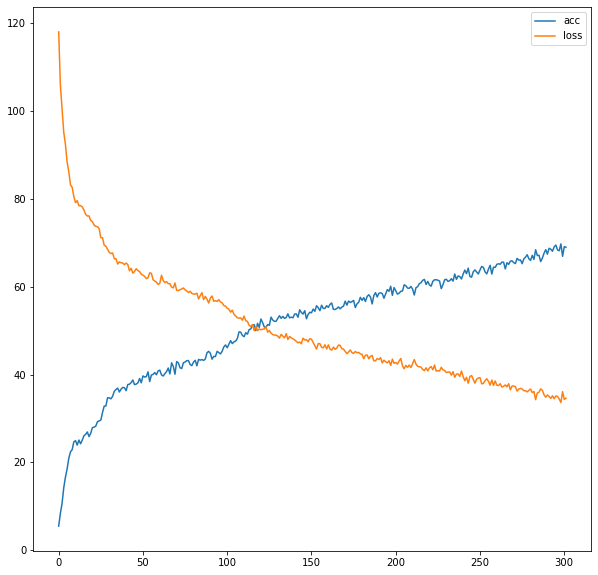

Epoch: 301 lr?: 0.6511555364245596 error: 0.30994743226849975  train_loss = tensor(34.6584, device='cuda:1') Acc = 69.00525677315002


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from IPython.display import clear_output
acc =[]
loss_train = [] 
for epoch in range(epochs):
    
    net.train()
    loss_sum = 0
    evaluation = []
    
    iter = 0
    with tqdm.tqdm(total=iter_per_epoch) as pbar:
        error_counter = 0
        
        for X, y in train_iter:
            trans1 = np.zeros(X.shape)
            trans2 = np.zeros(X.shape)
            #print("trans2 : {}".format(trans2.shape))
            #print("X shape : {}".format(X.shape))
            #print("X shape[3] : {}".format(X.shape[3]))
            
            for i in range(X.shape[0]):
                t1 = transform(X[i], "crop_resize")
                #print("t1 shape : {}".format(t1.shape))
                trans1[i] = t1.reshape(2,X.shape[2])
            #print("trans1 shape : {}".format(trans1))   
            for i in range(X.shape[0]):
                t2 = transform(X[i], 'permute')
                
                #print("t2 shape : {}".format(t2.shape))
                trans2[i] = t2.reshape(2,X.shape[2])
                
            trans = np.concatenate((trans1,trans2))
            
            trans = torch.tensor(trans, dtype=torch.float, device=device)
            
            output = net(trans)

            optimizer.zero_grad()

            l, lab_con, log_con = comtrast_loss(output, criterion)
            _, log_p = torch.max(log_con.data,1)
            evaluation.append((log_p == lab_con).tolist())
            l.backward()
            optimizer.step()
            loss_sum += l
            iter += 1
            pbar.set_description("Epoch %d, loss = %.2f" % (epoch, l.data))
            pbar.update(1)
        err = l.data
    evaluation = [item for sublist in evaluation for item in sublist]


    train_acc = sum(evaluation) / len(evaluation)
    error = 1 - train_acc
    current_lr = optimizer.param_groups[0]['lr']
    
    clear_output(wait=True)
    
    acc.append(train_acc*100)
    loss_train.append(loss_sum.data.cpu())
    #print(acc)
    #print(loss_train)
    do_plot_acc_loss(acc, loss_train)
    print("Epoch:", epoch,"lr?:", current_lr, "error:", error, " train_loss =", loss_sum.data, "Acc =",train_acc*100)
    #do_plot(loss_sum.data, error)
    scheduler_warmup.step()
    state = {"state_dict": net.state_dict(), "epoch": epoch}
    save_ckpt(state, best_err > error, model_save_dir)
    best_err = min(best_err, error)
            

### EVA

In [ ]:
net = resnet18(classification=True).to(device)
#net = nn.DataParallel(net)
checkpoint = torch.load(os.path.join("logs/resnet17_05160848",'best_w.pth'))
net.load_state_dict(checkpoint['state_dict'], strict=False)
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00001)

epochs_t = 70
lr_schduler = CosineAnnealingLR(optimizer, T_max=epochs_t - 10, eta_min=0.09)#default =0.07
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=10, after_scheduler=lr_schduler)
optimizer.zero_grad()
optimizer.step()
scheduler_warmup.step()


batch_size = 256

val_acc_list = []
n_train_samples = x_train.shape[0]
iter_per_epoch = n_train_samples // batch_size + 1
best_acc = -1

for epoch in range(epochs_t):
    net.train()
    loss_sum = 0
    evaluation = []
    iter = 0
    with tqdm.tqdm(total=iter_per_epoch) as pbar:
        for X, y in train_iter:
            #print("X shape : {}".format(X.shape))
            output = net(X)
            
            _, predicted = torch.max(output.data, 1)
            evaluation.append((predicted == y).tolist())
            optimizer.zero_grad()
            l = criterion(output, y)
            l.backward()
            optimizer.step()
            loss_sum += l
            iter += 1
            pbar.set_description("Epoch %d, loss = %.2f" % (epoch, l.data))
            pbar.update(1)
    evaluation = [item for sublist in evaluation for item in sublist]
    train_acc = sum(evaluation) / len(evaluation)
    current_lr = optimizer.param_groups[0]['lr']
    print("Epoch:", epoch,"lr:", current_lr," train_loss =", loss_sum.data, " train_acc =", train_acc)
    # scheduler.step()
    scheduler_warmup.step()
    val_loss = 0
    evaluation = []
    pred_v = []
    true_v = []
    with torch.no_grad():
        net.eval()
        for X, y in test_iter:
            output = net(X)
            _, predicted = torch.max(output.data, 1)
            evaluation.append((predicted == y).tolist())
            l = criterion(output, y)
            val_loss += l
            pred_v.append(predicted.tolist())
            true_v.append(y.tolist())
    evaluation = [item for sublist in evaluation for item in sublist]
    pred_v = [item for sublist in pred_v for item in sublist]
    true_v = [item for sublist in true_v for item in sublist]

    running_acc = sum(evaluation) / len(evaluation)
    val_acc_list.append(running_acc)
    print("val_loss =", val_loss, "val_acc =", running_acc)


    state = {"state_dict": net.state_dict(), "epoch": epoch}
    save_ckpt(state, best_acc < running_acc, model_save_dir, 'best_cls.pth')
    best_acc = max(best_acc, running_acc)

print("Highest acc:", max(val_acc_list))
